In [ ]:
!git add training_aws.ipynb

In [ ]:
!git commit 

7="~/SageMaker/forex_prediction/.git/COMMIT_EDITMSG" 24L, 637C# Please enter the commit message for your changes. Lines starting
# with '#' will be ignored, and an empty message aborts the commit.
#
# Committer: EC2 Default User <ec2-user@ip-172-16-70-209.ec2.internal>
#
# On branch master
# Your branch is up-to-date with 'origin/master'.
#
# Changes to be committed:
#new file:   training_aws.ipynb
#
# Changes not staged for commit:
#modified:   ../../Datasets/EURUSD/ene2004_nov2019/procesado.csv
#modified:   17Abril.ipynb
#modified:   21Abril.ipynb
#modified:   loadModel.ipynb
#modified:   training_aws.ipynb
#
# Untracked files:
#models/
#preProcessing_aws.ipynb
#procesado.csv

In [2]:
# Mawrer Amed Ramirez Martinez
# Preprocesamiento de archivo original de Dukascopy
# ms723737@iteso.mx

import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed 
set_random_seed(2)

from keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


import seaborn as sns
from scipy import stats

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import plotly.graph_objects as go

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd
from pandas.plotting import autocorrelation_plot
import math as m
import os, glob

In [3]:

RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 10
BATCH_SIZE = 32

TEST_SIZE = .19
VAL_SIZE = .0

START_IN = 50000
#total 99380

END_IN = 60000

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [4]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
DF_EURUSD_ASK = pd.read_csv('s3://forex323737/posprocessed/procesado.csv')

In [5]:
DF_EURUSD_ASK = DF_EURUSD_ASK.drop(['Datetime'], axis = 1)
DF_EURUSD_ASK = DF_EURUSD_ASK.drop(['Sell'], axis = 1)
DF_EURUSD_ASK = DF_EURUSD_ASK.drop(['Sell2'], axis = 1)
DF_EURUSD_ASK = DF_EURUSD_ASK.drop(['Buy'], axis = 1)
DF_EURUSD_ASK = DF_EURUSD_ASK.drop(['Buy2'], axis = 1)

In [6]:
DF_Full = DF_EURUSD_ASK
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc

print(DF_Full.shape)
print(DF_Full.columns)
print(DF_Full.head(10))

(99430, 8)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Pct_Range', 'HL_PCT',
       'Class'],
      dtype='object')
      Open     High      Low    Close      Volume  Pct_Range    HL_PCT  Class
0  1.25950  1.25960  1.25826  1.25910   6654.2002   0.000326  0.106425      0
1  1.25958  1.25960  1.25947  1.25951    660.6000   0.000000  0.010321      0
2  1.25955  1.25962  1.25944  1.25951   2091.0000  -0.000651  0.014291      0
3  1.25950  1.25965  1.25834  1.25869  10003.0996   0.000644  0.104076      0
4  1.25908  1.25960  1.25843  1.25950   7603.3999   0.000040  0.092894      0
5  1.25907  1.25960  1.25825  1.25955  10862.5996  -0.000056  0.107181      0
6  1.25914  1.25960  1.25482  1.25948  10160.4004  -0.000302  0.379522      0
7  1.25938  1.25950  1.24698  1.25910  13008.2002  -0.000024  0.994361      0
8  1.25900  1.25953  1.25726  1.25907   5518.8999   0.000079  0.180292      0
9  1.25915  1.25953  1.25864  1.25917   7611.2002  -0.000048  0.070681      0


In [7]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)
print('End: ', END_IN)


Total:  99430
Start:  50000
End:  60000


In [8]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:END_IN]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(10000, 8)


In [9]:
total = DF_Full.shape[0]
print('Total: ', total)

Total:  10000


In [10]:
#generate the VECTOR Y
close_y = DF_Full['Close'].iloc[1:]
close_y.columns = ['close_y']
print(close_y.tail())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


9995    1.32119
9996    1.32057
9997    1.31957
9998    1.32122
9999    1.32182
Name: Close, dtype: float64
(9999,)
9995    1.32057
9996    1.31957
9997    1.32122
9998    1.32182
9999    1.32182
Name: Close, dtype: float64
(10000,)


In [11]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)


Sum of %s: 0.19
count of Val and Test: 1900
end of train:  8100
count val:  0
count test:  1900
end_val 8100


In [12]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("Data Training Shape: ",data_training.shape)
print("Data Val Shape: ",data_val.shape)
print("Data Test Shape: ",data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]
print("")
print("Y Data Training Shape: ", data_training_y.shape)
print("Y Data Val Shape: ", data_val_y.shape)
print("Y Data Test Shape: ", data_test_y.shape)

Data Training Shape:  (8100, 8)
Data Val Shape:  (0, 8)
Data Test Shape:  (1900, 8)

Y Data Training Shape:  (8100,)
Y Data Val Shape:  (0,)
Y Data Test Shape:  (1900,)


In [13]:
data_training_array = np.array(data_training)
#data_training_array = data_training_array.reset_index()
print(data_training_array.shape)
np.where(np.isnan(data_training_array))
#print(data_training_array.shape)
np.any(np.isnan(data_training_array))

(8100, 8)


False

In [14]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
#data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)

[[0.61683608 0.61504934 0.62221817 ... 0.53398788 0.03845597 0.5       ]
 [0.62188812 0.61680489 0.62702177 ... 0.53660889 0.0138552  0.5       ]
 [0.62158378 0.61644167 0.62610969 ... 0.51727885 0.01828305 0.5       ]
 ...
 [0.64763528 0.640293   0.64885078 ... 0.5219031  0.0280247  0.5       ]
 [0.64300931 0.63611599 0.64258786 ... 0.50653722 0.04472548 0.5       ]
 [0.64100067 0.633634   0.64088532 ... 0.55067085 0.03837602 0.5       ]]


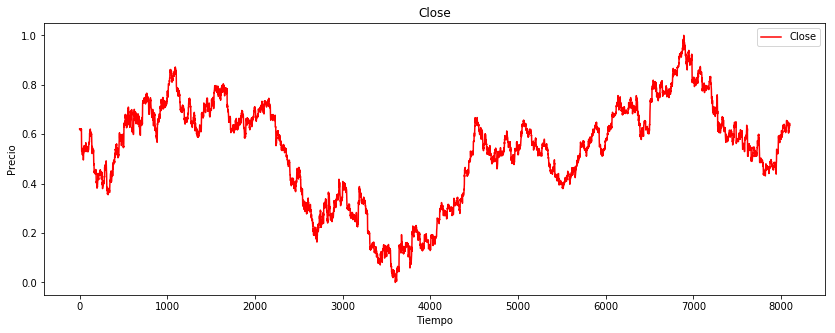

In [15]:
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[:,3], color = 'red', label = 'Close')
plt.title('Close')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

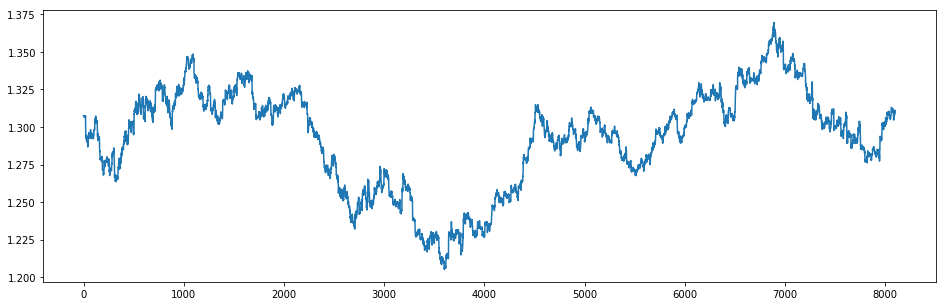

In [16]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [17]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(8049, 51, 8)
(8049,)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



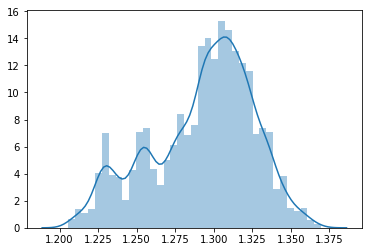

In [18]:
sns.distplot(y_train_np);


In [19]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 8)
(0, 8)
<bound method NDFrame.head of        Open     High      Low    Close      Volume  Pct_Range    HL_PCT  Class
0   1.30704  1.30738  1.30675  1.30687   3492.3501  -0.000161  0.048207      0
1   1.30686  1.30707  1.30655  1.30666   1407.6899  -0.001079  0.039796     -1
2   1.30668  1.30675  1.30517  1.30525   6402.8198  -0.000253  0.121050      0
3   1.30525  1.30631  1.30441  1.30492   8556.0000   0.000107  0.145603      0
4   1.30492  1.30598  1.30486  1.30506   8707.0498   0.000322  0.085820      0
5   1.30505  1.30585  1.30500  1.30548   5971.7500   0.000337  0.065110      0
6   1.30548  1.30600  1.30539  1.30592   4888.3701   0.000421  0.046710      0
7   1.30595  1.30670  1.30575  1.30647   3531.1799   0.000467  0.072715      0
8   1.30647  1.30715  1.30635  1.30708   5861.2402  -0.000038  0.061205      0
9   1.30708  1.30777  1.30662  1.30703   9263.9502   0.000459  0.087986      0
10  1.30703  1.30886  1.30640  1.30763  13383.8301   0.000520  0.188127      0
11  1.3

In [20]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(0,)
0    1.30666
1    1.30525
2    1.30492
3    1.30506
4    1.30548
5    1.30592
6    1.30647
7    1.30708
8    1.30703
9    1.30763
Name: Close, dtype: float64


In [21]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.61933167 0.61414129 0.62325185 0.61830574 0.11884148 0.52874281
  0.02272493 0.5       ]
 [0.61823605 0.61226466 0.62203575 0.61702775 0.04761934 0.48940293
  0.01731425 0.25      ]
 [0.61714042 0.6103275  0.61364466 0.60844693 0.2182773  0.52479614
  0.06958563 0.5       ]
 [0.6084363  0.6076639  0.60902347 0.60643866 0.29184043 0.54022163
  0.085381   0.5       ]
 [0.60642766 0.6056662  0.6117597  0.60729065 0.29700103 0.54941144
  0.04692186 0.5       ]
 [0.60721894 0.60487923 0.61261097 0.60984664 0.20354986 0.55006324
  0.03359908 0.5       ]
 [0.60983627 0.60578728 0.61498237 0.61252434 0.16653633 0.55366648
  0.02176227 0.5       ]
 [0.61269706 0.61002482 0.61717135 0.61587147 0.1201681  0.55562611
  0.03849139 0.5       ]
 [0.61586219 0.61274896 0.62081965 0.61958374 0.19977431 0.5339874
  0.03108693 0.5       ]
 [0.61957514 0.61650221 0.62246139 0.61927945 0.31602746 0.55528981
  0.04831523 0.5       ]]


In [22]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(0,)
(0,)


In [23]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 8)
(1900, 8)


(1951, 8)

In [24]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(1900,)


(1951,)

In [25]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.61933167 0.61414129 0.62325185 0.61830574 0.11884148 0.52874281
  0.02272493 0.5       ]
 [0.61823605 0.61226466 0.62203575 0.61702775 0.04761934 0.48940293
  0.01731425 0.25      ]
 [0.61714042 0.6103275  0.61364466 0.60844693 0.2182773  0.52479614
  0.06958563 0.5       ]
 [0.6084363  0.6076639  0.60902347 0.60643866 0.29184043 0.54022163
  0.085381   0.5       ]
 [0.60642766 0.6056662  0.6117597  0.60729065 0.29700103 0.54941144
  0.04692186 0.5       ]
 [0.60721894 0.60487923 0.61261097 0.60984664 0.20354986 0.55006324
  0.03359908 0.5       ]
 [0.60983627 0.60578728 0.61498237 0.61252434 0.16653633 0.55366648
  0.02176227 0.5       ]
 [0.61269706 0.61002482 0.61717135 0.61587147 0.1201681  0.55562611
  0.03849139 0.5       ]
 [0.61586219 0.61274896 0.62081965 0.61958374 0.19977431 0.5339874
  0.03108693 0.5       ]
 [0.61957514 0.61650221 0.62246139 0.61927945 0.31602746 0.55528981
  0.04831523 0.5       ]]


In [26]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(1900, 51, 8)
(1900,)


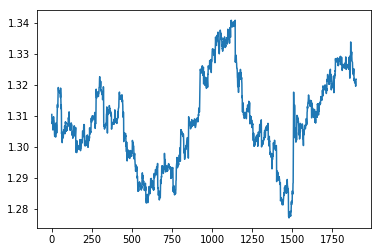

In [27]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



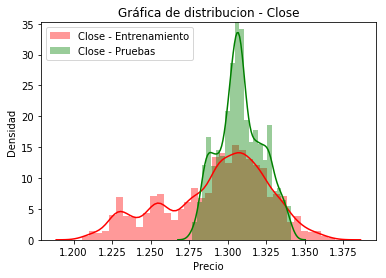

In [28]:
sns.distplot(y_train_np, color='red', label = 'Close - Entrenamiento');
sns.distplot(y_test_np, color='green', label = 'Close - Pruebas');
plt.title('Gráfica de distribucion - Close')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.legend()
plt.show()

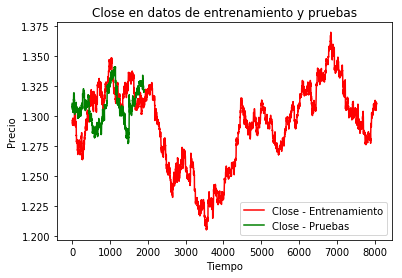

In [29]:
# Y de Val y Test comparados
pyplot.plot(y_train_np, color = 'red', label = 'Close - Entrenamiento')
#pyplot.plot(y_test_np)
pyplot.plot(y_test_np, color = 'green', label = 'Close - Pruebas')

plt.title('Close en datos de entrenamiento y pruebas')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [30]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
8


In [31]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 120, activation = 'relu'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [32]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [33]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [34]:
regressior.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 51, 51)            12240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 60)            26880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 51, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 180,841
Trainable params: 180,841
Non-trainable params: 0
_________________________________________________________________


In [35]:
pwd = os.getcwd()
path = os.path.join(pwd,'models')
print(path)

/home/ec2-user/SageMaker/forex_prediction/Jupyter Notebooks/IDI4/models


In [36]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=path + '/model-{epoch:02d}.hdf5', verbose=1)

In [37]:
%%time

history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8049 samples
Epoch 1/10
8049/8049 [==============================] - 138s 17ms/sample - loss: 0.0671 - mean_squared_error: 0.0671 - mean_absolute_error: 0.0959 - mean_absolute_percentage_error: 7.4251 - cosine_proximity: 0.9928
Epoch 2/10
4704/8049 [================>.............] - ETA: 55s - loss: 3.3196e-04 - mean_squared_error: 3.3196e-04 - mean_absolute_error: 0.0144 - mean_absolute_percentage_error: 1.1161 - cosine_proximity: 1.0000

KeyboardInterrupt: 

In [38]:
today = datetime.today()
date_today = today.strftime("%d_%m_%y")
print("date_today =", date_today)

MODEL_NAME =  date_today + "_model_LSTM.hdf5"

regressior.save( path + '/' + MODEL_NAME)


date_today = 14_05_20


In [39]:
print(history.history.keys())

NameError: name 'history' is not defined

In [ ]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()